# Hands-on Activity 4.1 - Object Detection and Recognition Techniques

Technological Institute of the Philippines | Quezon City - Computer Engineering
--- | ---
Course Code: | CPE 313
Code Title: | Advanced Machine Learning and Deep Learning
2nd Semester | AY 2023-2024
<hr> | <hr>
<u>**ACTIVITY NO.** | **Hands-on Activity 4.1 Object Detection and Recognition Techniques**
**Name** | Mendoza, Paulo
<hr> | <hr>
**Section** | CPE32S8
**Date Performed**: | March 19, 2024
**Date Submitted**: | March 19, 2024
**Instructor**: | Engr. Roman M. Richard

<hr>

## 1. Objectives

This activity aims to introduce students to object detection and recongition through the use of histogram of gradients (HoG), image pyramids and sliding windows in OpenCV.sad

## 2. Intended Learning Outcomes (ILOs)
After this activity, the students should be able to:
* Demonstrate object detection and recognition using histogram of gradients, image pyramids and sliding windows in OpenCV.
* Evaluate the performance of the object detection and recognition techniques in OpenCV.

## 3. Procedures and Outputs

When it comes to recognizing and detecting objects, there are a number of techniques used in computer vision, which we'll be examining:
* Histogram of Oriented Gradients
* Image pyramids
* Sliding windows

Unlike feature detection algorithms, these are not mutually exclusive techniques, rather, they are complimentary. You can perform a Histogram of Oriented Gradients (HOG) while applying the sliding windows technique. So, let's take a look at HOG first and understand what it is.

### History of Gradients (HoG) Descriptors

HOG is a feature descriptor, so it belongs to the same family of algorithms, such as SIFT, SURF, and ORB.

It is used in image and video processing to detect objects. Its internal mechanism is really clever; an image is divided into portions and a gradient for each portion is calculated. We've observed a similar approach when we talked about face recognition through LBPH.

HOG, however, calculates histograms that are not based on color values, rather, they are based on gradients. As HOG is a feature descriptor, it is capable of delivering the type of information that is vital for feature matching and object detection/recognition.

Before diving into the technical details of how HOG works, let's first take a look at how HOG sees the world; here is an image of a truck:

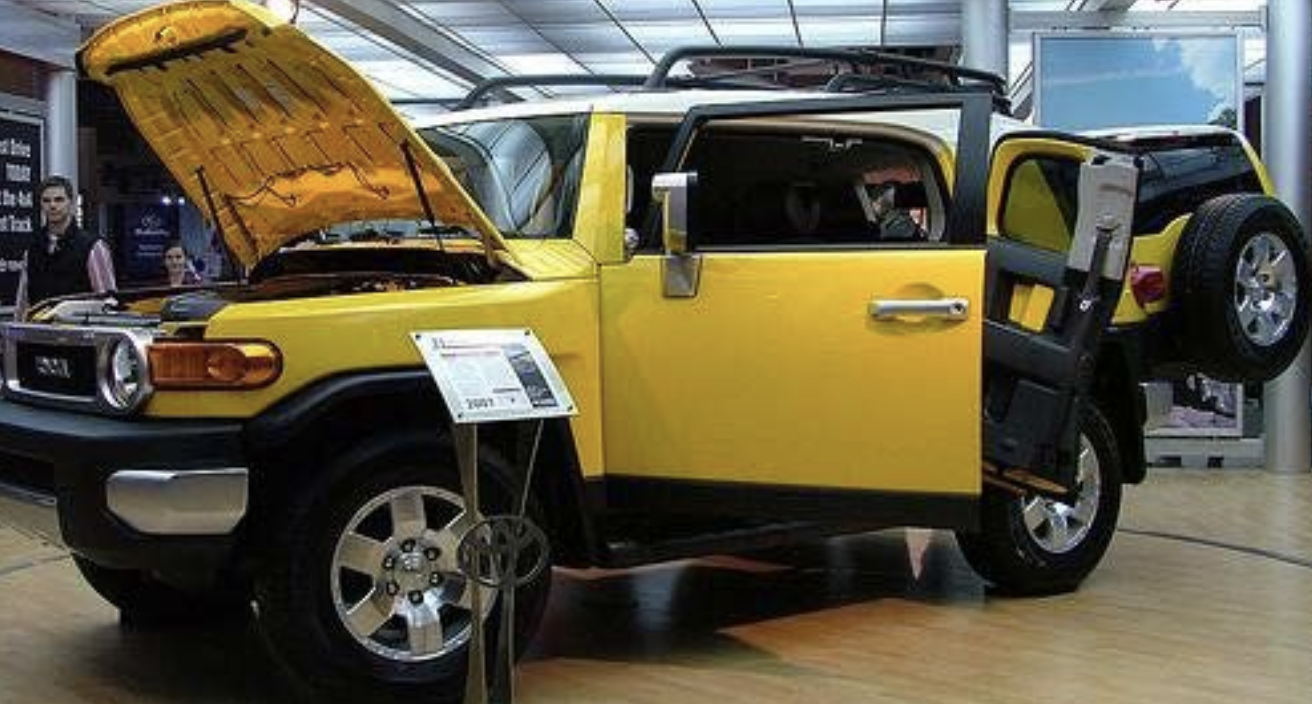

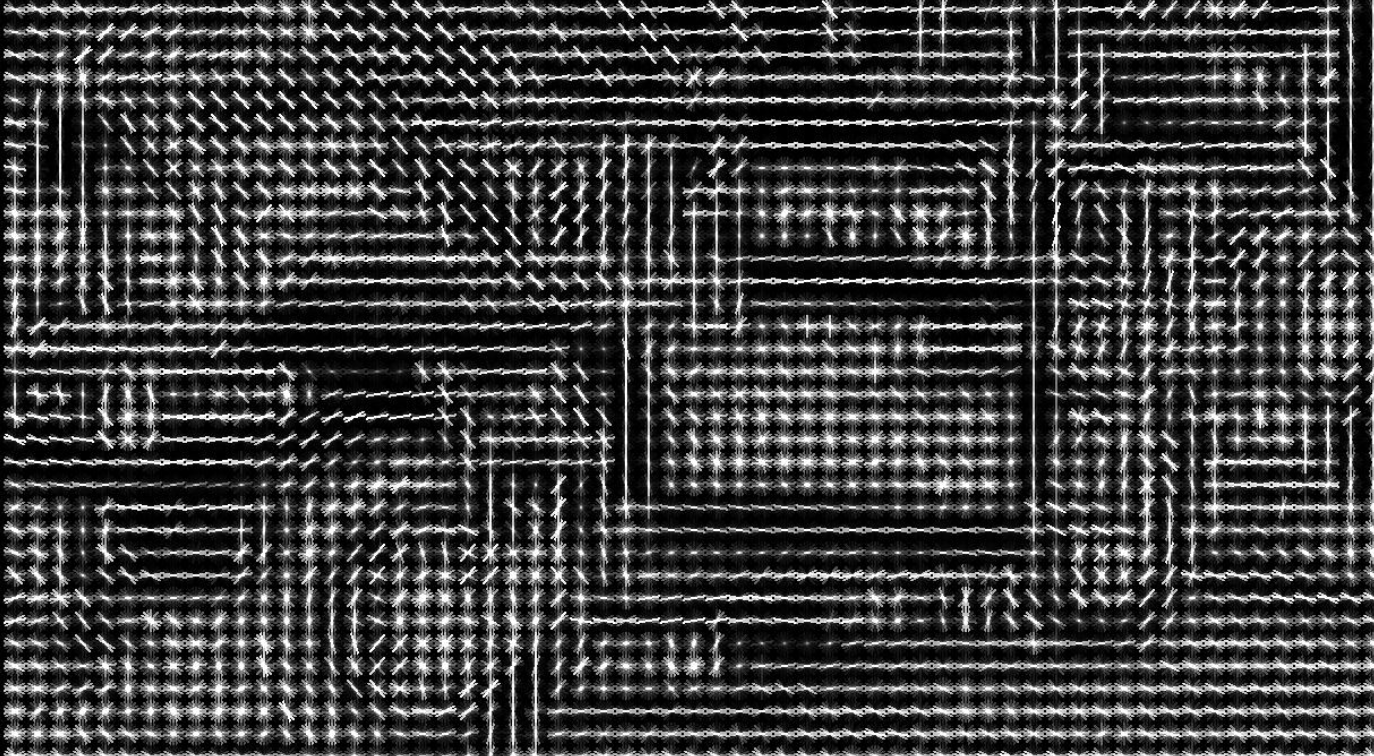

**Question: Here you are shown the original image and how HOG sees the image. Analyze the output and provide a description. Are you able to see that it is the same image?**

Yes, It was able to give distinction to each part of the truck. We can see the rim of the tires which are represented in an full asterisk while the tires are lines that is angled forming a circle. It was able to display the contures of the car by ustilising lines representation in a grid.

The extrapolation of histograms into descriptors is quite a complex process.
- First, local histograms for each cell are calculated. The cells are grouped into larger regions called blocks. These blocks can be made of any number of cells, but Dalal and Triggs found that 2x2 cell blocks yielded the best results when performing people detection.
- A block-wide vector is created so that it can be normalized, accounting for variations in illumination and shadowing (a single cell is too small a region to detect such variations). This improves the accuracy of detection as it reduces the illumination and shadowing difference between the sample and the block being examined.
- Simply comparing cells in two images would not work unless the images are identical (both in terms of size and data).

There are two main problems to resolve:
1. Location
2. Scale

**The Scale Issue**

Imagine, for example, if your sample was a detail (say, a bike) extrapolated from a larger image, and you're trying to compare the two pictures. You would not obtain the same gradient signatures and the detection would fail (even though the bike is in both pictures).

**The Location Issue**

Once we've resolved the scale problem, we have another obstacle in our path: a potentially detectable object can be anywhere in the image, so we need to scan the entire image in portions to make sure we can identify areas of interest, and within these areas, try to detect objects. Even if a sample image and object in the image are of identical size, there needs to be a way to instruct OpenCV to locate this object. So, the rest of the image is discarded and a comparison is made on potentially matching regions.

*To obviate these problems, we need to familiarize ourselves with the concepts of image pyramid and sliding windows.*

### Image Pyramids

Many of the algorithms used in computer vision utilize a concept called pyramid. An image pyramid is a multiscale representation of an image. This diagram should
help you understand this concept:

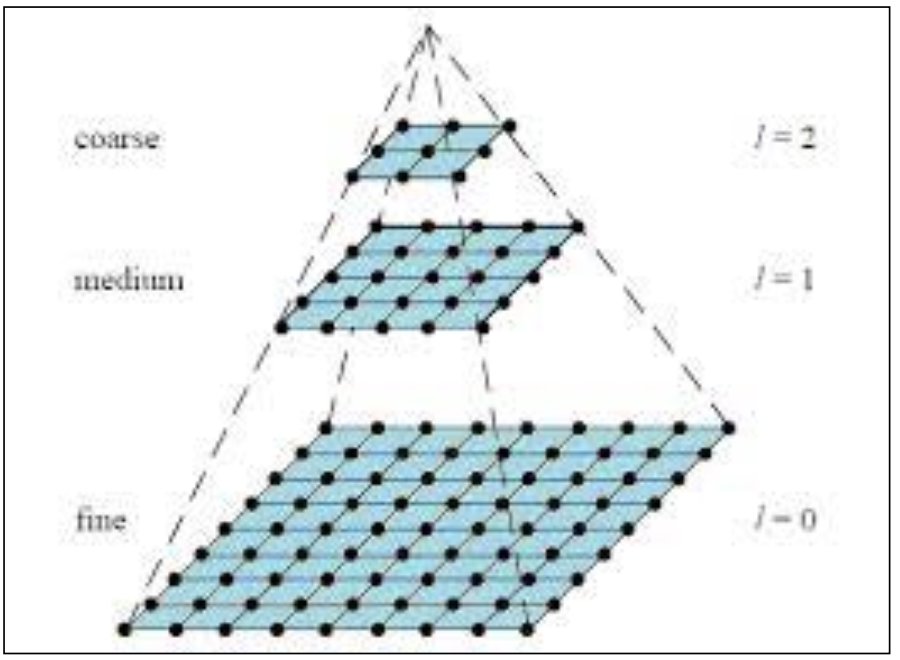

A multiscale representation of an image, or an image pyramid, helps you resolve the problem of detecting objects at different scales. The importance of this concept is easily explained through real-life hard facts, such as it is extremely unlikely that an object will appear in an image at the exact scale it appeared in our sample image.
Moreover, you will learn that object classifiers (utilities that allow you to detect objects in OpenCV) need training, and this training is provided through image databases made up of positive matches and negative matches. Among the positives, it is again unlikely that the object we want to identify will appear in the same scale throughout the training dataset.

**Follow the steps and create a function that can make an image Pyramid**:

1. Take an image.
2. Resize (smaller) the image using an arbitrary scale parameter.
3. Smoothen the image (using Gaussian blurring).
4. If the image is larger than an arbitrary minimum size, repeat the process from step 1.

Demonstrate by creating a function and showing the different scales of the image.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


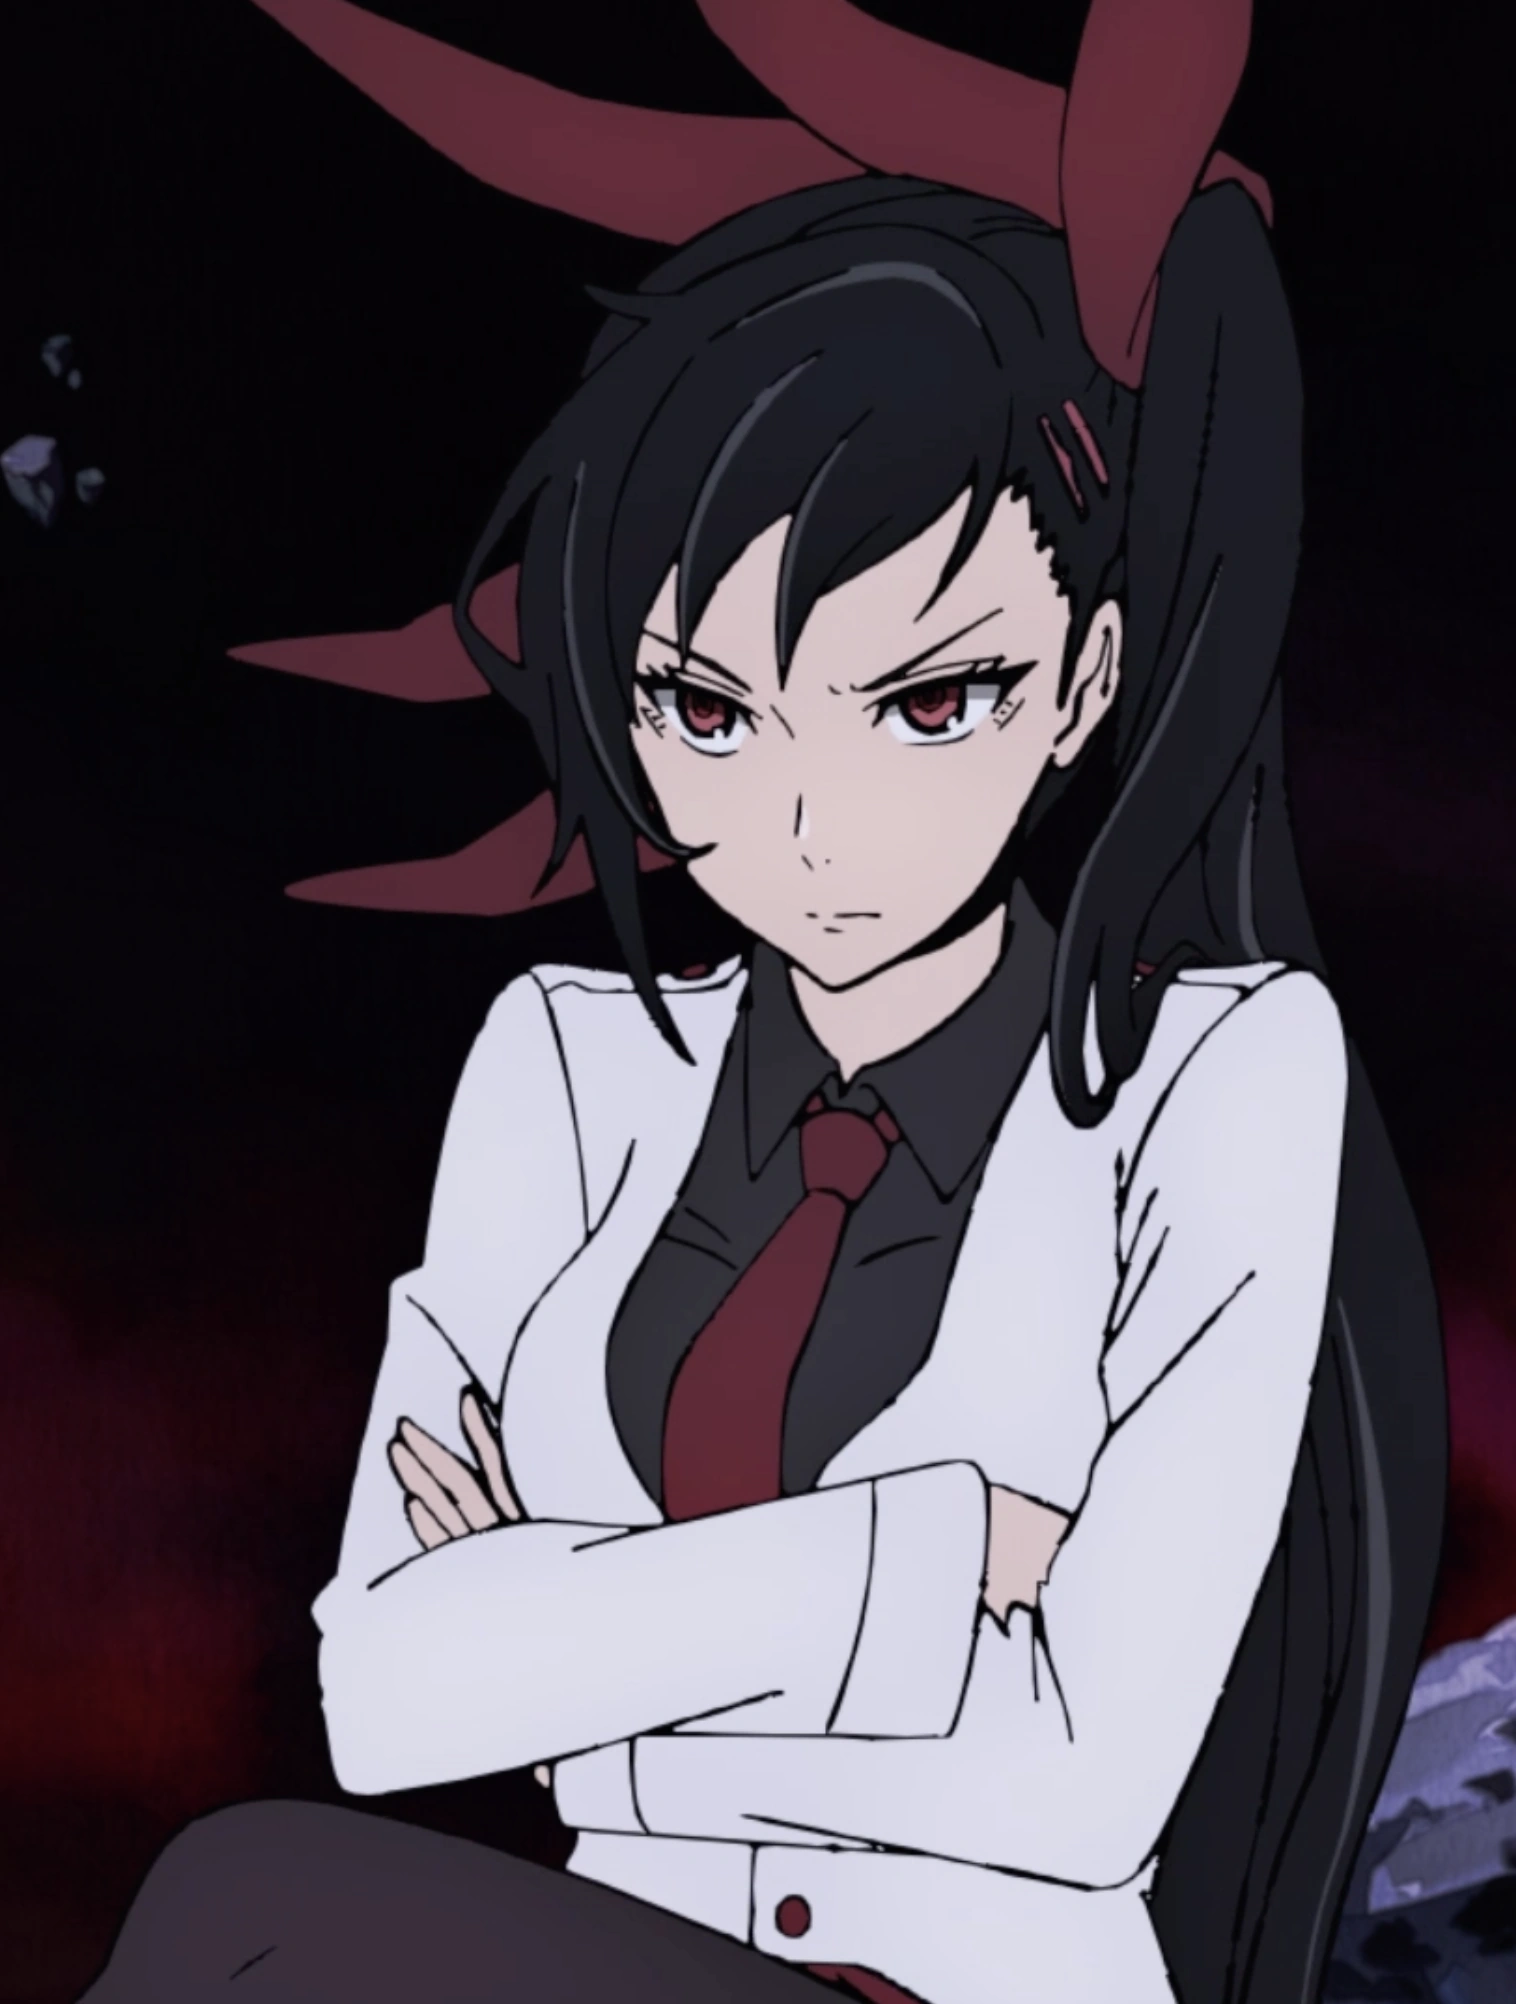

In [3]:
import cv2
from google.colab.patches import cv2_imshow


image_path = "/content/drive/MyDrive/data sci 3 files/mounted files/yuri_TOG.png"
# Load the PNG file
image = cv2.imread(image_path )

# Display the image
cv2_imshow(image)


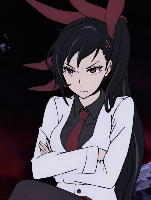

In [6]:
def resize_image(image, scale = 0.5):
    """
        Resize the input image based on a scale factor.
    """
    # Get the height and width of the original image
    height, width = image.shape[:2]

    # Calculate the new dimensions based on the scale factor
    new_width = int(width * scale)
    new_height = int(height * scale)

    # Resize the image using the calculated dimensions
    resized_image = cv2.resize(image, (new_width, new_height))

    return resized_image


image_resized = resize_image(image, 0.1)
cv2_imshow(image_resized)

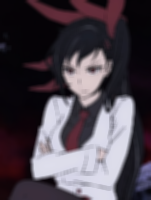

In [11]:
def apply_gaussian_blur(image, kernel_size=(5, 5), sigma_x=5):
    """
    kernel_size = the higher the more blurry, cannot be even since it is not centered
    sigma_x = controls the spread the higher means it considers that farther pixel

    """
    blurred_image = cv2.GaussianBlur(image, kernel_size, sigma_x)
    return blurred_image

image_resized_gaussian = apply_gaussian_blur(image_resized)
cv2_imshow(image_resized_gaussian)

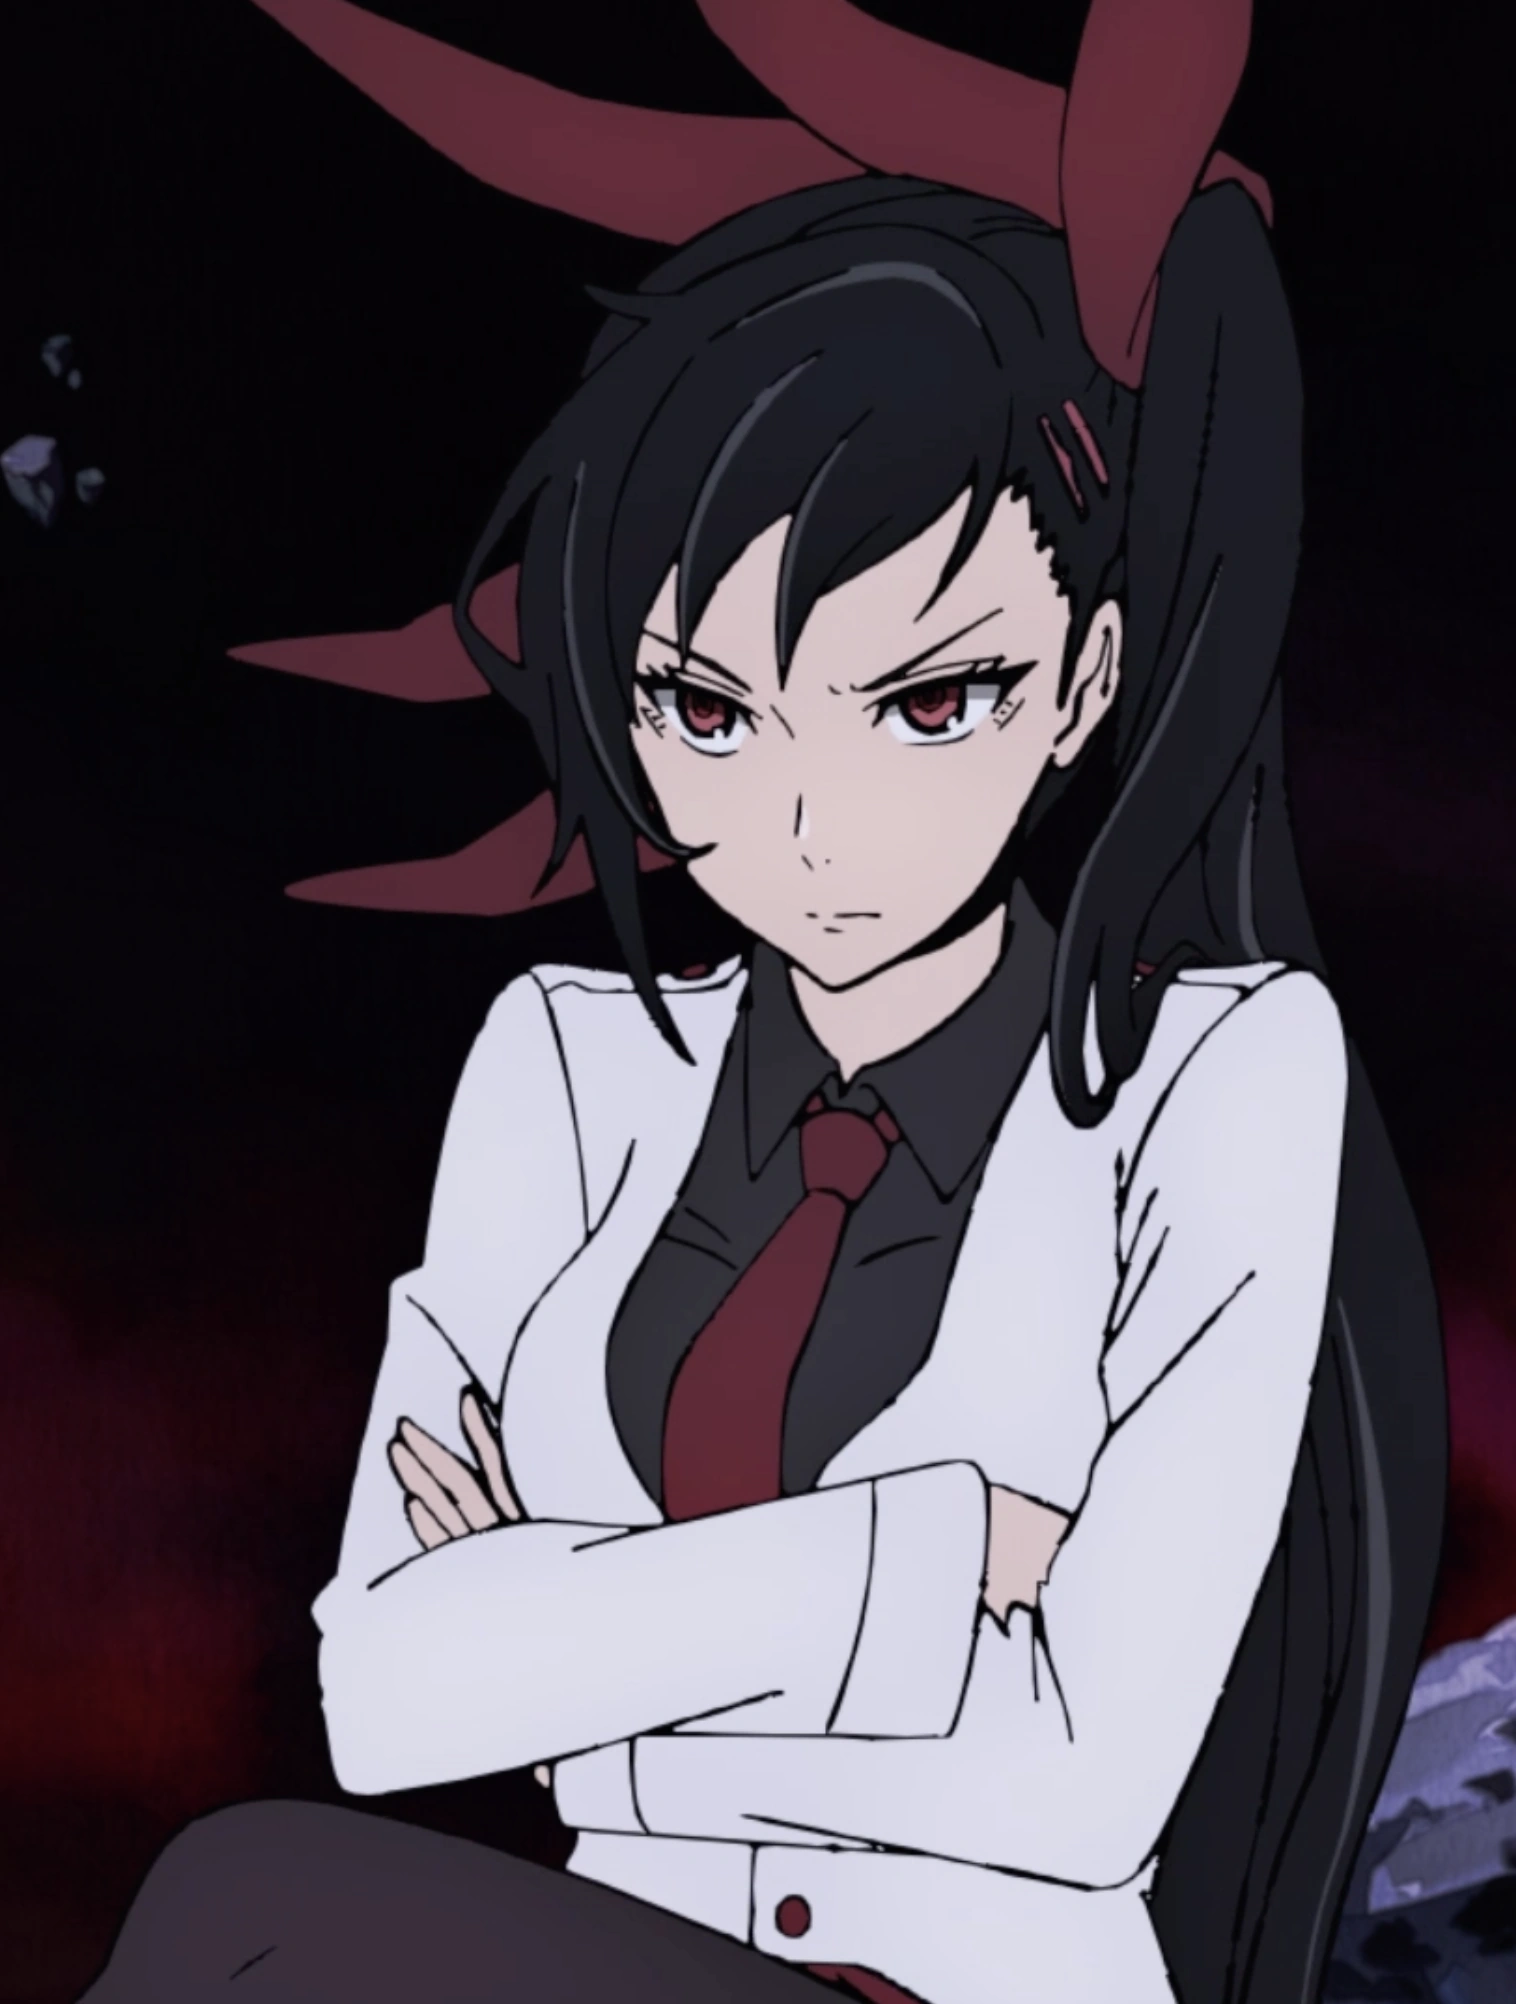

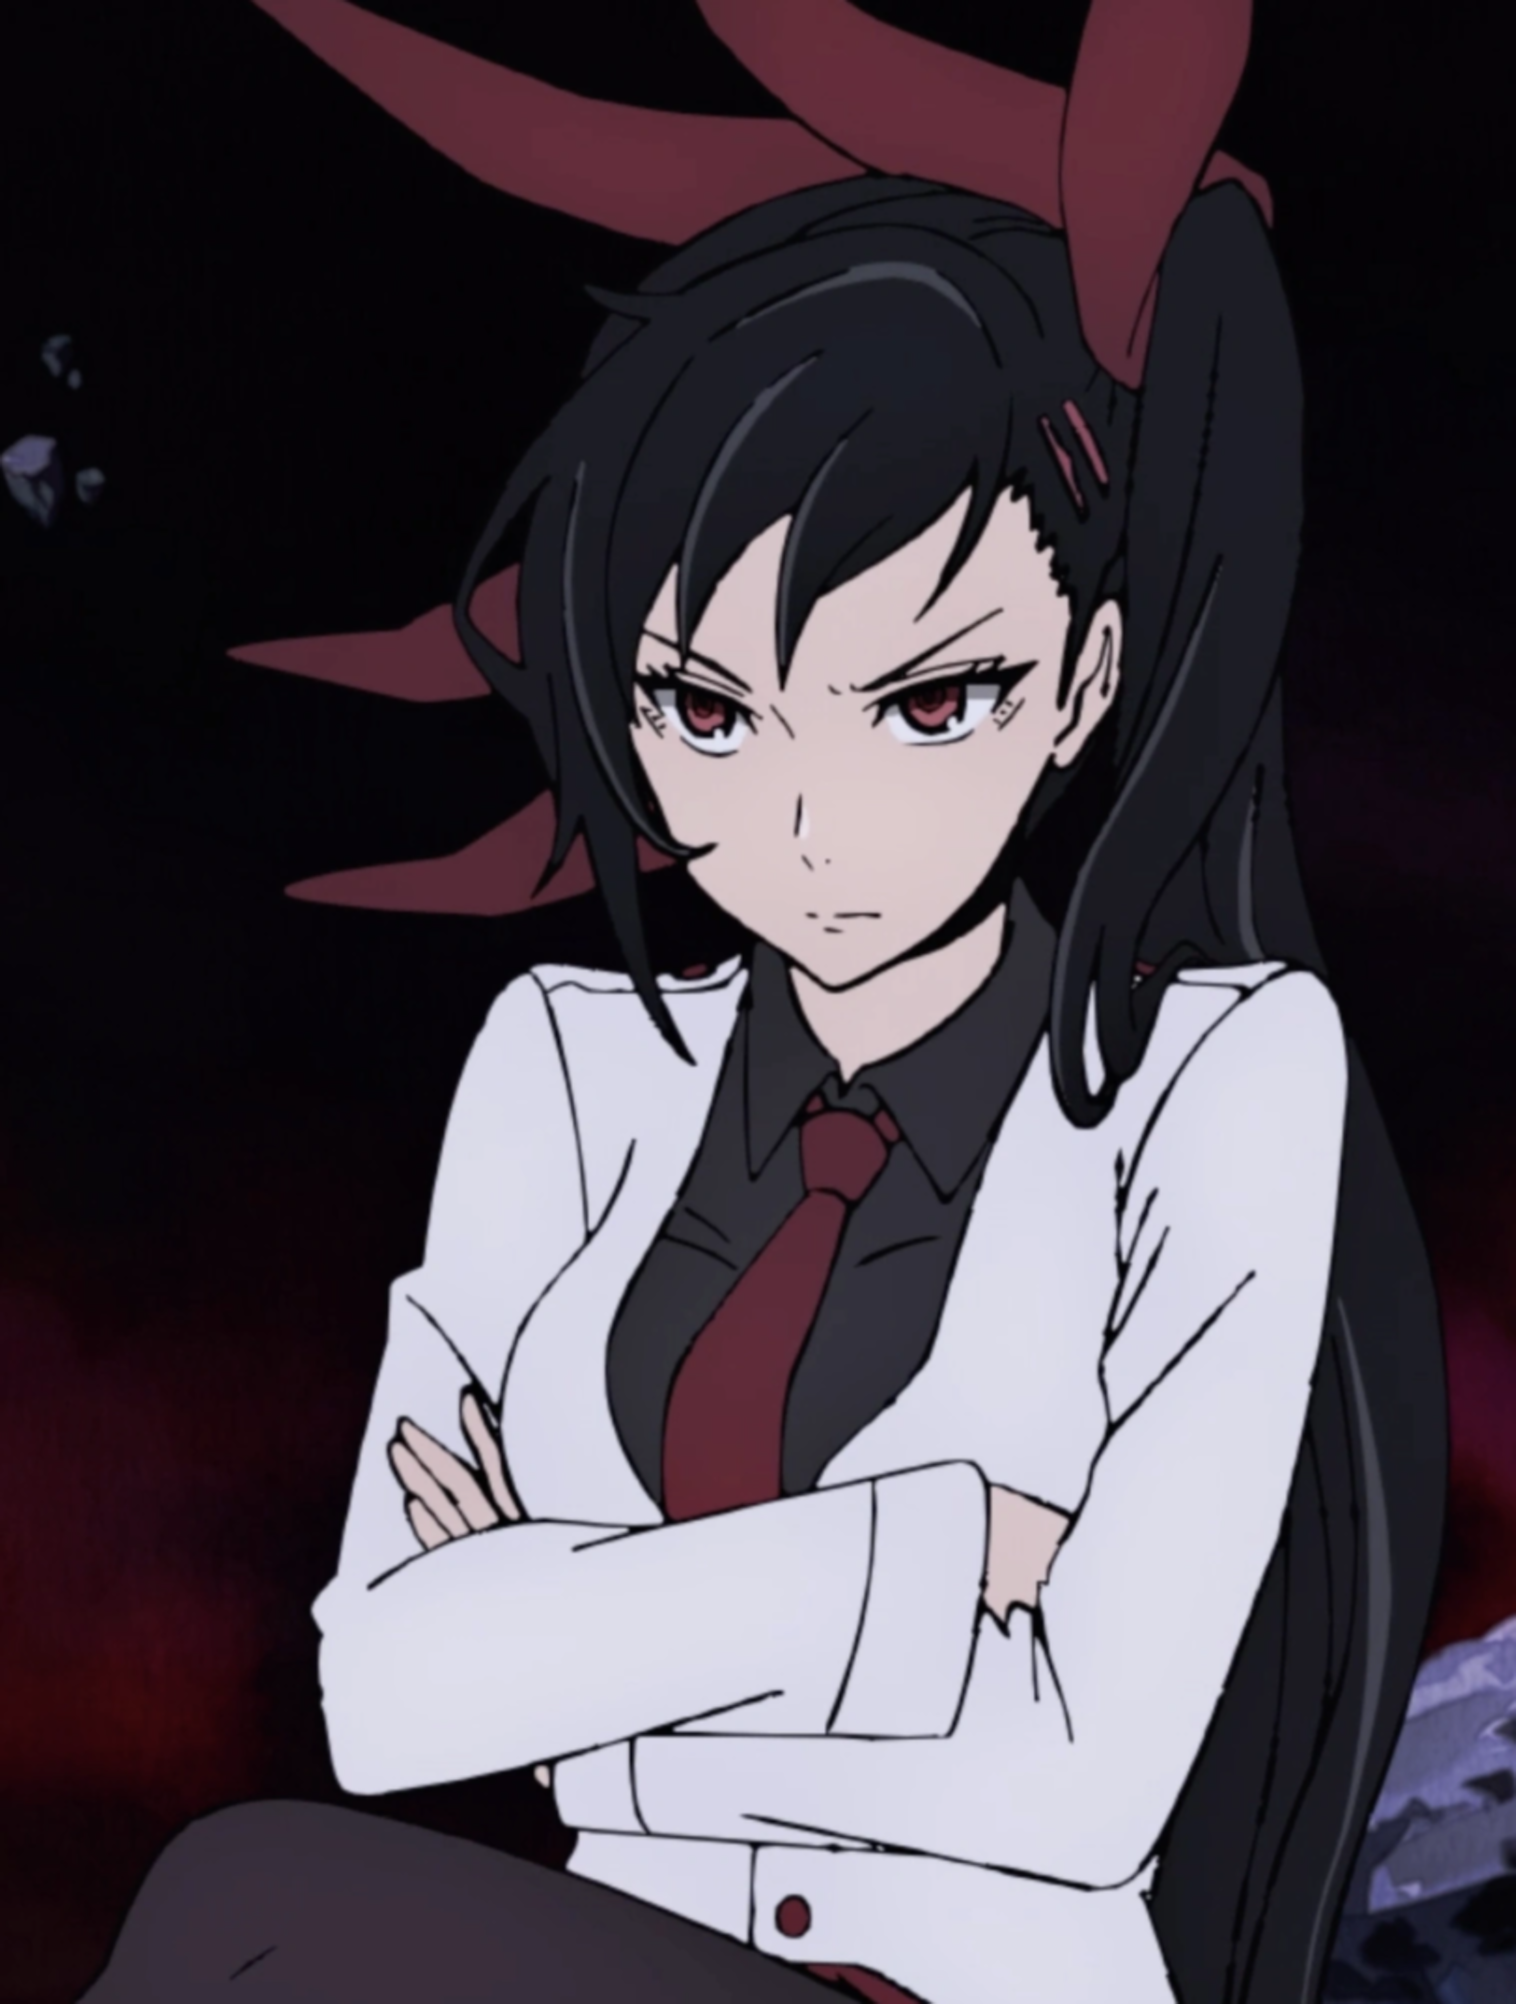

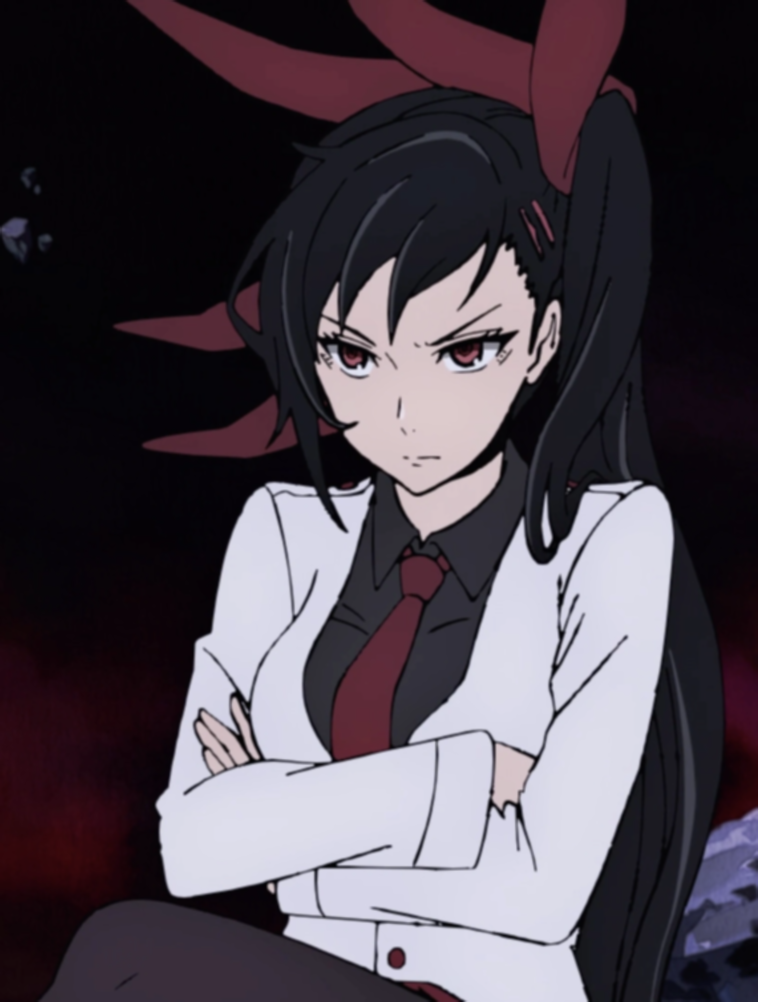

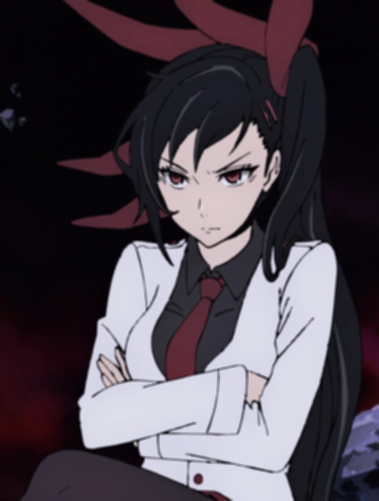

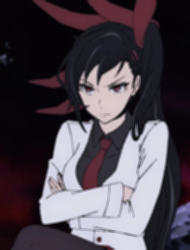

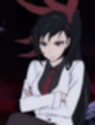

In [26]:
def generate_image_pyramid(image, scale_factor=0.5, min_size=(30, 30)):
    """
    Generate an image pyramid for the input image.

    Args:
    - image: Input image (numpy array).
    - scale_factor: Scaling factor for downsampling each level of the pyramid (float).
    - min_size: Minimum size threshold for the smallest level of the pyramid (tuple: width, height).

    Returns:
    - List containing images at different scales (list of numpy arrays).
    """
    pyramid = [image]
    while True:
        # Resize the image using the scale factor
        resized_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)

        # Check if the resized image meets the minimum size threshold
        if resized_image.shape[0] < min_size[1] or resized_image.shape[1] < min_size[0]:
            break
        resized_image_blurred = cv2.GaussianBlur(image, (3,3), 5)
        # Add the resized image to the pyramid
        pyramid.append( resized_image_blurred)

        # Update the image for the next iteration
        image = resized_image

    return pyramid

image_pyramid = generate_image_pyramid(image)

for i in range(6):
  cv2_imshow(image_pyramid[i])




**Question: How does the performance of your functions in obtaining the image pyramid perform in iterations of the image that decrease until the scale factor is achieved?**

### Sliding Windows

Sliding windows is a technique used in computer vision that consists of examining the shifting portions of an image (sliding windows) and operating detection on those using image pyramids. This is done so that an object can be detected at a multiscale level.

Sliding windows resolves location issues by scanning smaller regions of a larger image, and then repeating the scanning on different scales of the same image.

With this technique, each image is decomposed into portions, which allows discarding portions that are unlikely to contain objects, while the remaining portions are classified.

There is one problem that emerges with this approach, though: **overlapping regions**.

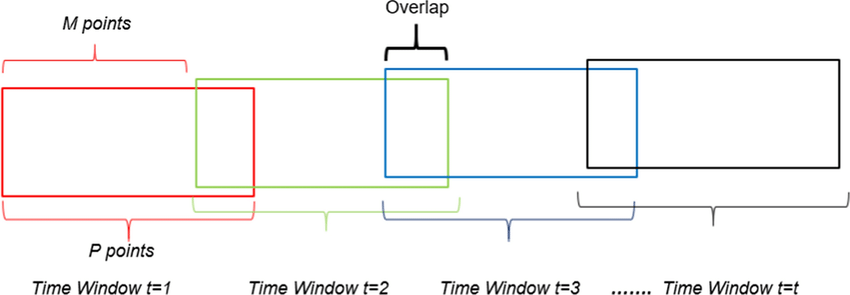

Here's where non-maximum suppression comes into play: given a set of overlapping regions, we can suppress all the regions that are not classified with the maximum score.

**Question: Research on the topic and provide ample discussion, what is non-maximum (or non-maxima) suppression? Provide examples and code.**

The general approach behind non-maximum suppression is as follows:
1. Once an image pyramid has been constructed, scan the image with the sliding window approach for object detection.
2. Collect all the current windows that have returned a positive result (beyond a certain arbitrary threshold), and take a window, W, with the highest response.
3. Eliminate all windows that overlap W significantly.
4. Move on to the next window with the highest response and repeat the
process for the current scale.

**Question: Demonstrate the above given steps using a custom image and creating code in Python using OpenCV**

## 4. Supplementary Activity

Perform **People Detection** using the aforementioned methods.

In [1]:
import cv2
import numpy as np

def is_inside(o, i):
  ox, oy, ow, oh = o
  ix, iy, iw, ih = i
  return ox > ix and oy > iy and ox + ow < ix + iw and oy + oh < iy + ih

def draw_person(image, person):
  x, y, w, h = person
  cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
  img = cv2.imread("../images/people.jpg")
  hog = cv2.HOGDescriptor()
  hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
  found, w = hog.detectMultiScale(img)
  found_filtered = []

  for ri, r in enumerate(found):
    for qi, q in enumerate(found):
      if ri != qi and is_inside(r, q):
        break
      else:
        found_filtered.append(r)
  for person in found_filtered:
    draw_person(img, person)

cv2.imshow("people detection", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'img' is not defined

Your output should display bounding boxes around people detected. Your task is:
* Debug the code if your intended output is not being displayed.
* Enumerate the problems encountered and actions taken.
* Evaluate the performance of the object detection technique.



## 5. Summary, Conclusions and Lessons Learned

This is an essential technique. Because previously what we are doing it training a model using pictures that have same dimension and size mostly the images maximize that size. But in the real application of a A.I. model when deployed what the camera would see is the whole view including the subject and the background. The subject may not be in the center or covering the entire frame hence the need to be able to detect that image even if it is small and blurry than the images used when training the model.

# Google Collab Link:

https://colab.research.google.com/drive/1NVrzX1otRsmsqtoFMMgLNhT5qtOoRr4b?usp=sharing

<hr/>

***Proprietary Clause***

*Property of the Technological Institute of the Philippines (T.I.P.). No part of the materials made and uploaded in this learning management system by T.I.P. may be copied, photographed, printed, reproduced, shared, transmitted, translated, or reduced to any electronic medium or machine-readable form, in whole or in part, without the prior consent of T.I.P.*